In [1]:
import pandas as pd
import seaborn as sns
import cv2
from matplotlib import pyplot as plt
from random import choice
import numpy as np

In [ ]:
pad = "../../data/csv/"
image_pad =  "../../data/Images/CrimeScenes/"

participants = pd.read_csv(pad+"participants.csv")
fixations = pd.read_csv(pad+"fixations.csv")

fix = fixations.merge(participants, how="left", on="Participant")
#remove fixations outside the screen
fix = fix[(fix["X"] > 0) & (fix["X"] < 1024) & (fix["Y"] > 0) & (fix["Y"] < 768)]

fix.head()

,Image,Scene,ROI,Participant,FixDur,FixNr,Start,End,X,Y,Name,NextROI,experience
0,1,1,0,2.0,103.0,1.0,7.0,109.0,510.9,381.0,Elsewhere,Bottle_on_table,Control
1,1,1,22,2.0,77.0,2.0,236.0,312.0,450.8,307.0,Bottle_on_table,Floor,Control
2,1,1,9,2.0,300.0,3.0,347.0,646.0,414.5,447.9,Floor,Body,Control
3,1,1,8,2.0,165.0,4.0,687.0,851.0,468.6,619.1,Body,Elsewhere,Control
4,1,1,0,2.0,461.0,5.0,876.0,1336.0,465.4,687.9,Elsewhere,Elsewhere,Control


In [3]:
selection = fix[(fix["Scene"] == 3) & (fix["Image"] == 2) & (fix["Participant"] == 2)]
selection.head()

,Image,Scene,ROI,Participant,FixDur,FixNr,Start,End,X,Y,Name,NextROI,experience
1550,2,3,7,2.0,297.0,1.0,62.0,358.0,482.9,353.3,NaN,NaN,Control
1551,2,3,5,2.0,345.0,2.0,400.0,744.0,345.9,465.1,NaN,NaN,Control
1552,2,3,8,2.0,622.0,3.0,787.0,1408.0,458.5,377.4,NaN,NaN,Control
1553,2,3,12,2.0,357.0,4.0,1441.0,1797.0,542.7,382.5,NaN,NaN,Control
1554,2,3,13,2.0,221.0,5.0,1987.0,2207.0,531.3,379.6,NaN,NaN,Control


In [4]:
# Compute dwell times as a percentage of the overall time
fix_dur = fix.groupby(["Participant","Image","Scene","Name"]).sum("FixDur").reset_index()[["Participant","Image","Scene","Name","FixDur"]]
total_fix_dur = fix.groupby(["Participant","Image","Scene"]).sum("FixDur").reset_index()[["Participant","Image","Scene","FixDur"]]
fix_dur = fix_dur.merge(total_fix_dur, how = "left", on = ["Participant","Image", "Scene"])
fix_dur["Perc"] = 100*fix_dur["FixDur_x"]/fix_dur["FixDur_y"]
fix_dur.head()

,Participant,Image,Scene,Name,FixDur_x,FixDur_y,Perc
0,2.0,1,1,Back_chair,2549.0,138662.0,1.838283
1,2.0,1,1,Back_wall,4729.0,138662.0,3.410451
2,2.0,1,1,Body,10201.0,138662.0,7.356738
3,2.0,1,1,Bookcase,4104.0,138662.0,2.959715
4,2.0,1,1,Bottle_on_table,77.0,138662.0,0.055531


In [5]:
#Dwell times across participants
across_su = fix_dur.groupby(["Image","Scene","Name"]).mean("Perc").reset_index()[["Image","Scene","Name","Perc"]]
across_su.head()

,Image,Scene,Name,Perc
0,1,1,Back_chair,1.460160
1,1,1,Back_wall,1.750207
2,1,1,Body,14.638782
3,1,1,Bookcase,2.361961
4,1,1,Bottle_on_table,0.439076


<Axes: xlabel='Perc', ylabel='Name'>

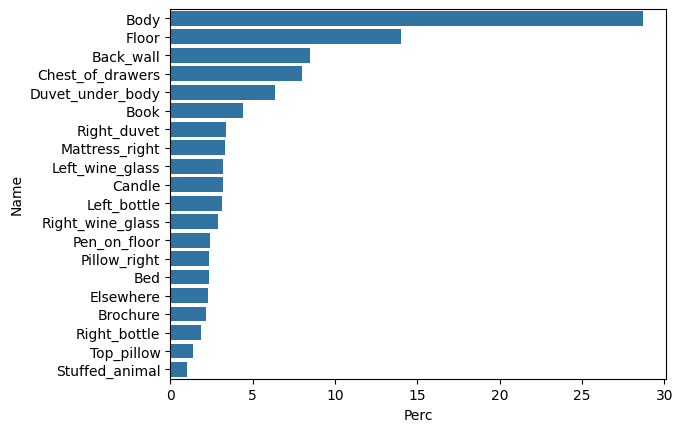

In [6]:
#Top x dwell times
one_scene = across_su[(across_su["Image"] == 1) &  (across_su["Scene"] == 2)].sort_values("Perc", ascending=False)
top_ROIs = one_scene.head(20)

sns.barplot(top_ROIs, y = "Name", x = "Perc")

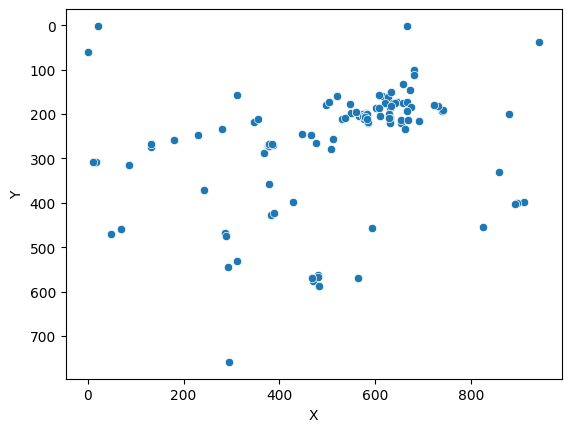

In [7]:
#The remaining dwell times are inside the image, most likely at the boundaries of the ROIs
elsewhere = fix[(fix["Image"] == 1) &  (fix["Scene"] == 2) & (fix["Name"] == "Elsewhere")]

ax = sns.scatterplot(data = elsewhere, x = "X", y = "Y")
ax.invert_yaxis()

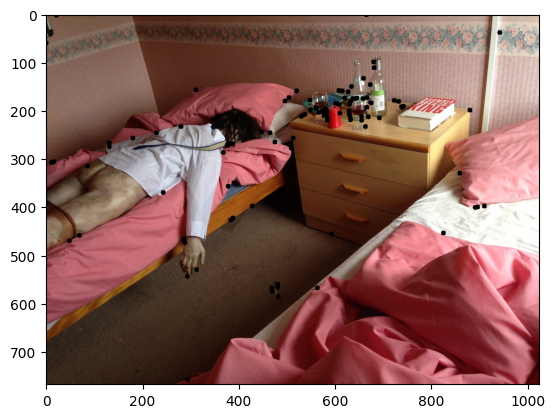

In [8]:
ROI = pd.read_csv(pad + "ROIs.csv")

img = cv2.imread(image_pad + "scene_2_1.png")
for idx, row in elsewhere.iterrows():
    img = cv2.circle(img, (int(row["X"]),int(row["Y"])), 5, (0,0,0), -1)
    xnew, ynew = int(row["Y"]+choice([-1,1])), int(row["Y"]+choice([-1,1]))
    [B,G,R] = img[ynew, xnew,:]
    this_ROI = ROI[(ROI["C1"] == R) & (ROI["C2"] == G) & (ROI["C3"] == B) & (ROI["Image"] == 1) &  (ROI["Scene"] == 2)]
    if len(this_ROI) > 0:
        this_name = this_ROI.iloc[0]["Name"]
        elsewhere.loc[idx, "Name"] = this_name
    
img = img[:,:,::-1]
plt.imshow(img)

['Stairs' 'Stairs_wall' 'Handrail' 'Router' 'Wall_kitchen' 'Bottles'
 'Wooden_wall' 'Body' 'Floor' 'Can_on_floor' 'Fallen_chair' 'Back_wall'
 'Ceiling' 'CCTV' 'Curtains' 'Smoke_detector' 'Windows' 'Bookcase' 'Table'
 'Cans_on_table' 'Lamp_above_table' 'Bottle_on_table' 'Back_chair'
 'Fallen_glass_on_table' 'Newspaper_on_table' 'Knife_on_floor'
 'Lamp_in_front' 'Hatch_in_ceiling' 'Side_wall' 'Radiator' 'Chair_right'
 'Items_near_wall' 'Wall_on_right']


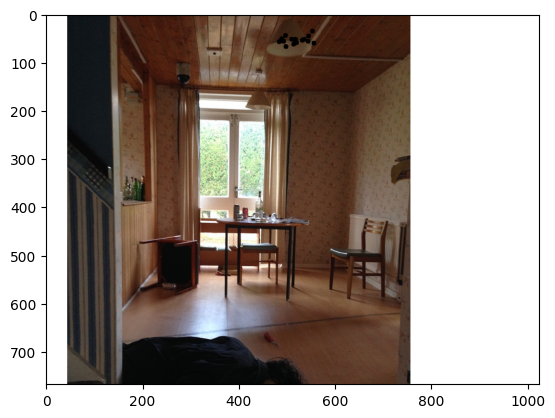

In [9]:
ROI = pd.read_csv(pad + "ROIs.csv")

scene_nr = 1
image_nr= 1
ROI_name = "Lamp_in_front"

scene = fix[(fix["Image"] == image_nr) &  (fix["Scene"] == scene_nr) & (fix["Name"] == ROI_name)]
print(ROI[(ROI["Image"] == image_nr) &  (ROI["Scene"] == scene_nr)]["Name"].unique())

img = cv2.imread(image_pad + f'scene_{scene_nr}_{image_nr}.png')
height,width, colours = img.shape
maxx,maxy = 1024, 768
bg = 255*np.ones((maxy,maxx,3),dtype=np.uint8)
startX, startY = int((maxx-width)/2), int((maxy-height)/2)
if scene_nr ==1 and image_nr == 1:
    startX = 44 #value found in the Matlab code which must have been based on the comparison with the Eyelink viewer
bg[startY:startY+height, startX:startX+width,:] = img

for idx, row in scene.iterrows():
    bg = cv2.circle(bg, (int(row["X"]),int(row["Y"])), 5, (0,0,0), -1)
    
bg = bg[:,:,::-1]
plt.imshow(bg)

['Stairs' 'Stairs_wall' 'Handrail' 'Router' 'Wall_kitchen' 'Bottles'
 'Wooden_wall' 'Body' 'Floor' 'Can_on_floor' 'Fallen_chair' 'Back_wall'
 'Ceiling' 'CCTV' 'Curtains' 'Smoke_detector' 'Windows' 'Bookcase' 'Table'
 'Cans_on_table' 'Lamp_above_table' 'Bottle_on_table' 'Back_chair'
 'Fallen_glass_on_table' 'Newspaper_on_table' 'Knife_on_floor'
 'Lamp_in_front' 'Hatch_in_ceiling' 'Side_wall' 'Radiator' 'Chair_right'
 'Items_near_wall' 'Wall_on_right']


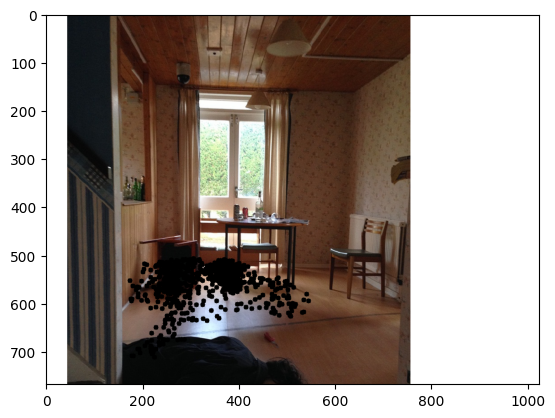

In [ ]:
def load_image(scene_nr, image_nr):
    maxx,maxy = 1024, 768
    img = cv2.imread(image_pad + f'scene_{scene_nr}_{image_nr}.png')
    height,width, colours = img.shape
    bg = 255*np.ones((maxy,maxx,3),dtype=np.uint8)
    startX, startY = int((maxx-width)/2), int((maxy-height)/2)
    if scene_nr ==1 and image_nr == 1:
        startX = 44 #value found in the Matlab code which must have been based on the comparison with the Eyelink viewer
    bg[startY:startY+height, startX:startX+width,:] = img
    return(bg)

ROI = pd.read_csv(pad + "ROIs.csv")

scene_nr = 1
image_nr = 1
ROI_name = "Body"

scene_data = fix[(fix["Image"] == image_nr) &  (fix["Scene"] == scene_nr) & (fix["Name"] == ROI_name)]
print(ROI[(ROI["Image"] == image_nr) &  (ROI["Scene"] == scene_nr)]["Name"].unique())

img = load_image(scene_nr, image_nr)

for idx, row in scene_data.iterrows():
    img = cv2.circle(img, (int(row["X"]),int(row["Y"])), 5, (0,0,0), -1)
    
img = img[:,:,::-1]
plt.imshow(img)


In [11]:
ROI

,Scene,Image,ROI,C1,C2,C3,Name,ExitEntry,Movable,Evidence
0,1,1,1,255,17,17,Stairs,Yes,No,No
1,1,1,2,172,171,115,Stairs_wall,No,No,No
2,1,1,3,224,18,39,Handrail,No,No,No
3,1,1,4,202,102,248,Router,No,No,No
4,1,1,5,33,78,70,Wall_kitchen,No,No,No
...,...,...,...,...,...,...,...,...,...,...
143,3,2,16,224,124,43,Left_jar,No,Yes,Yes
144,3,2,17,43,224,43,Right_plastic_cup,No,Yes,Yes
145,3,2,18,218,236,218,Napkin_on_table,No,Yes,Yes
146,3,2,19,224,43,43,Right_jar,No,Yes,Yes
